# Predicting the Sale Price of Bulldozers using Machine Learning

## 1. Problem Definition
> In this project, I will be predicting the future price for bulldozers given historical data on bulldozer sales.


## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are three main datasets:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.
For more on evaluation check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

## 4. Features

Kaggle provides a data dictionary that details all features in the dataset. This can be found in the Data Dictionary.xlsx file.

### Import data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn


In [6]:
# Import training and validation sets 
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory = False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

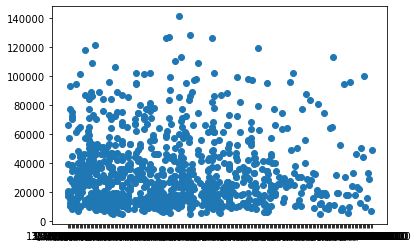

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

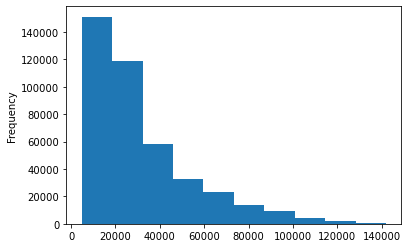

In [8]:
df["SalePrice"].plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using `parse_dates` parameter.

In [8]:
# Import data again but this time parse dates

df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory = False, parse_dates=["saledate"])

In [9]:
df.saledate.dtype

dtype('<M8[ns]')

In [13]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

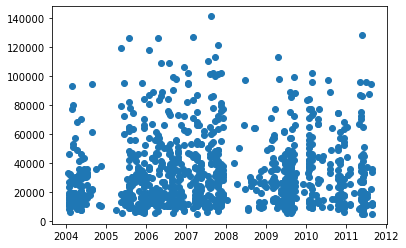

In [10]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Sort DataFrame by saledate

In [11]:
df.sort_values(by = ["saledate"], inplace = True, ascending = True)
df.saledate.head(10)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

In [12]:
df_copy = df.copy()

### Add dataframe parameters for `saledate` column

In [14]:
df_copy["saleYear"] = df_copy["saledate"].dt.year
df_copy["saleMonth"] = df_copy["saledate"].dt.month
df_copy["saleDay"] = df_copy["saledate"].dt.day
df_copy["dayOfWeek"] = df_copy["saledate"].dt.dayofweek
df_copy["dayOfYear"] = df_copy["saledate"].dt.dayofyear

In [28]:
df_copy.head().T

,205615,63166,140257,233186,142491
SalesID,1646770,1329619,1502329,1728883,1508502
SalePrice,9500,27500,35000,30000,21000
MachineID,1126363,436674,1300019,1523610,1153157
ModelID,8434,4089,4155,9105,4138
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1987,1977,1986,1972
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [15]:
# We can remove saledate now
df_copy.drop("saledate", axis = 1, inplace = True)
# Note, error below occurred because this cell was run twice. Can't remove saledate if it doesn't exist anymore!

## 5. Data Manipulation

### Convert strings into categories
We need all data to be numerical. A way to do this is using pandas categories.

In [16]:
# Find columns which contain strings and convert them to categories

for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        df_copy[label] = content.astype("category").cat.as_ordered()

In [17]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [18]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [43]:
df_copy.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

### Check missing values

In [19]:
# Check percentage of missing values in each column
df_copy.isna().sum()/len(df_copy)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

#### Save preprocessed data

In [20]:
df_copy.to_csv("data/bluebook-for-bulldozers/preprocessed.csv", index=False)

## Fill Missing Values

### Fill numeric values first

In [21]:
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)
            # binary column to save which values were missing
            df_copy[label+"_is_missing"] = pd.isnull(content)
            # fill with median
            df_copy[label] = content.fillna(content.median()) 
            
          
        

auctioneerID
MachineHoursCurrentMeter


In [58]:
df_copy["auctioneerID"].isna().sum(), df_copy["MachineHoursCurrentMeter"].isna().sum()

(0, 0)

In [59]:
df_copy["auctioneerID_is_missing"].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

### Filling and turning categorical variables into numbers

In [22]:
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)
        # Binary column to mark missing values
        df_copy[label+"_is_missing"] = pd.isnull(content)
        # Turn the columns into numbers using category code. Plus 1 is added to avoid -1 on missing values
        df_copy[label] = pd.Categorical(content).codes + 1

        
    

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [66]:
df_copy.state.dtypes

dtype('int8')

In [23]:
df_copy.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that the data is fully numerical with no missing values, the data is ready to be modelled.

## 6. Modelling

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
len(df_copy)

412698

In [69]:
%%time
# instantiate model
model = RandomForestRegressor(n_jobs = -1, random_state = 42)
# fit model
model.fit(df_copy.drop("SalePrice", axis=1), df_copy["SalePrice"])

CPU times: user 27min 21s, sys: 18 s, total: 27min 39s
Wall time: 11min 6s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [70]:
# Training score
model.score(df_copy.drop("SalePrice", axis=1), df_copy["SalePrice"])

0.9875412365465408

In [26]:
 # Split data into training and validation sets
df_val = df_copy[df_copy.saleYear == 2012]
df_train = df_copy[df_copy.saleYear != 2012]

In [27]:
len(df_val), len(df_train)

(11573, 401125)

In [28]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_val, y_val = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

### Build Evalutation Function

The competition uses RMSLE (root mean squared log error).

In [29]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle (y_test, y_preds):
    """
    Calculated RMSLE b/w predictions and true values
    """
    return(np.sqrt(mean_squared_log_error(y_test, y_preds)))

# Create function to evaluate model on a few different levels

def evaluate(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_val, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_val, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_val, val_preds)    
             }
    return scores
    

### Testing our model on a subset (to tune hyperparameters)

It takes far too long to fit our model on the entire data set ~400k training samples

In [30]:
# Change max samples value in RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples = 10000)

In [31]:
%%time
model.fit(X_train, y_train)

CPU times: user 54.1 s, sys: 1.31 s, total: 55.4 s
Wall time: 18.4 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [32]:
evaluate(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [98]:
%%time
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10,100,10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]
          }
# instantiate randomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid, n_iter=5,
                              cv=5, verbose=True)

# fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  3.2min finished


CPU times: user 1min 46s, sys: 16.3 s, total: 2min 2s
Wall time: 3min 24s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [99]:
# best params 
rs_model.best_params_

{'n_estimators': 80,
 'min_samples_split': 16,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [100]:
# Evaluate our new model
evaluate(rs_model)

{'Training MAE': 6850.653426877605,
 'Valid MAE': 8380.48253710089,
 'Training RMSLE': 0.3043783840148321,
 'Valid RMSLE': 0.3327347558231454,
 'Training R^2': 0.7934576750423633,
 'Valid R^2': 0.7651004428928292}

The score got worse. It makes sense since we only iterated over 5 combinations in the param_distributions grid as n_iter was set equal to 5.

Check n_iter = 100. This will take a couple hours at least.

In [101]:
%%time
# instantiate randomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions=rf_grid, n_iter=100,
                              cv=5, verbose=True)

# fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 60.5min finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [102]:
evaluate(rs_model)

{'Training MAE': 5586.482528721303,
 'Valid MAE': 7195.124355540194,
 'Training RMSLE': 0.25871806412327497,
 'Valid RMSLE': 0.29468283649153365,
 'Training R^2': 0.8589504471422714,
 'Valid R^2': 0.8293610387230843}

In [103]:
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

### Train a model with the best hyperparameters
**Note** These were found after 100 iterations of `RandomizedSearchCV`

In [113]:
%%time

ideal_model = RandomForestRegressor(n_estimators = 60, min_samples_split=2,
                                    min_samples_leaf=1, max_samples=None, max_features="auto",
                                    max_depth=None, random_state=42)

# Fit ideal model on entire training set
ideal_model.fit(X_train, y_train)

CPU times: user 9min 27s, sys: 10.1 s, total: 9min 37s
Wall time: 10min 52s


RandomForestRegressor(n_estimators=60, random_state=42)

In [115]:
evaluate(ideal_model)

{'Training MAE': 1600.1275058481353,
 'Valid MAE': 6163.031091045249,
 'Training RMSLE': 0.08540063563782649,
 'Valid RMSLE': 0.2564196659521263,
 'Training R^2': 0.9870619548949472,
 'Valid R^2': 0.8715005661033581}

In [33]:
%%time

ideal_model_2 = RandomForestRegressor(n_estimators = 40, min_samples_split=14,
                                    min_samples_leaf=1, max_samples=None, max_features=0.5,
                                    max_depth=None, random_state=42)

# Fit ideal model on entire training set
ideal_model_2.fit(X_train, y_train)

CPU times: user 2min 28s, sys: 788 ms, total: 2min 29s
Wall time: 2min 29s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      random_state=42)

In [34]:
evaluate(ideal_model_2)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371858,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

## Predictions on Test Data 

In [35]:
# Import test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", low_memory=False, parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


### Preprocessing the data (get test data in same format as training, validation sets)

In [36]:
def preprocess_data(df):
    """
    Performs transformations on df and returns the transformed df.
    """
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["dayOfWeek"] = df["saledate"].dt.dayofweek
    df["dayOfYear"] = df["saledate"].dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Find columns which contain strings and convert them to categories
    for label, content in df.items():
        if pd.api.types.is_string_dtype(content):
            df[label] = content.astype("category").cat.as_ordered()
            
    # Fill numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # binary column to save which values were missing
                df[label+"_is_missing"] = pd.isnull(content)
                # fill with median
                df[label] = content.fillna(content.median()) 
    
    # Converting categorical values into numbers and filling missing categories (category codes + 1)
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Binary column to mark missing values
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn the columns into numbers using category code. Plus 1 is added to avoid -1 on missing values
            df[label] = pd.Categorical(content).codes + 1
    
    return df



In [37]:
# Process test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [38]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [39]:
# We can find how the columns differ by using tests
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [40]:
# There were no missing auctioneerID values in test data frame, 
# so we have to manually add a acutioneerID_is_missing column

df_test["auctioneerID_is_missing"] = False
df_test["auctioneerID_is_missing"].head()

0    False
1    False
2    False
3    False
4    False
Name: auctioneerID_is_missing, dtype: bool

In [41]:
test_preds = ideal_model_2.predict(df_test)

In [42]:
# Put predictions into the required format of the competition
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test.SalesID
df_preds["SalesPrice"] = test_preds
df_preds.head()

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708


In [43]:
# Export predictions data
df_preds.to_csv("data/bluebook-for-bulldozers/test_preds.csv", index=False)

## Feature Importance

In [44]:
ideal_model_2.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [53]:
# Helper function for plotting feature importance 

def plot_features(columns, importances, n=50):
    df = (pd.DataFrame({"features": columns, "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # plot the dataframe
    fig, ax = plt.subplots(figsize= (10,20))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_xlabel("Features")
    ax.set_ylabel("Feature Importance")
    ax.invert_yaxis()

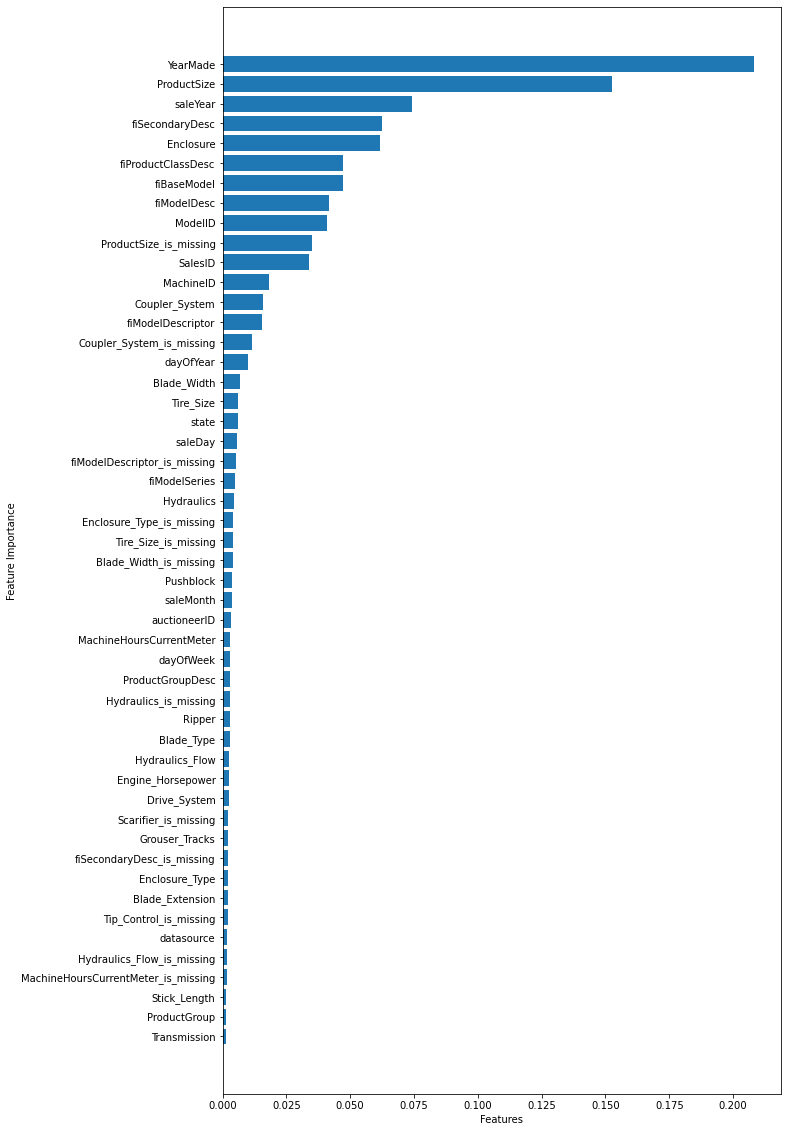

In [54]:
plot_features(X_train.columns, ideal_model_2.feature_importances_)